In [1]:
import time
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import check_random_state
from sklearn.ensemble import RandomForestClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sclblpy as sp


*** Thanks for importing sclblpy! ***
You can use the 'upload()' function to upload your models.
To inspect your currently uploaded models, use `endpoints()`.
Check the docs at https://pypi.org/project/sclblpy/ for more info. 



In [3]:
# Get the data

# Download data
# X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
# np.save("mnist_784_X", X, allow_pickle=True)
# np.save("mnist_784_y", y, allow_pickle=True)

# Load data from a local file
X = np.load("./dataset/mnist_784_X.npy", allow_pickle=True)
y = np.load("./dataset/mnist_784_y.npy", allow_pickle=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
def preprocess_image(img):
    # Grab just the R channel (RGB all have the same values here)
    img = img[:, :, 0]

    # Invert values
    img = 1 - img
    
    # Scale values from 0.0 – 1.0 to 0.0 – 255.0
    img = img * 255.0
    
    return img

def display_image(img):
    plt.imshow(img, cmap="binary")
    
def make_prediction(model, sample):
    x = sample.reshape(1, -1)
    prediction = model.predict(x)
    print(f"Prediction: {prediction[0]}")
    return prediction[0]

def reshape_mnist_sample(sample):
    return sample.reshape(28, 28)

def get_random_digit(data=X_train):
    random_index = np.int(np.floor(np.random.random() * len(data)))
    random_index

    return data[random_index]

def make_prediction_for_random_digit(model, data=X_train):
    img = get_random_digit(data)
    img = reshape_mnist_sample(img)
    display_image(img)
    make_prediction(model, img)
    
# Plot a bunch of images from the train data
def plot_train_data():
    n_rows = 2
    n_cols = 5
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            img = X_train[index].reshape(28, 28)
            plt.imshow(img, cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title([y_train[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

# Plot external images
def plot_external_data(model):
    n_rows = 2
    n_cols = 5
    plt.figure(figsize=(n_cols * 2, n_rows * 2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            print(index)
            plt.subplot(n_rows, n_cols, index + 1)
            filename = f"./images/experiment/{index}_28px.png"
            img = mpimg.imread(filename)
            plt.imshow(img, cmap="binary", interpolation="nearest")
            plt.axis('off')
            img = preprocess_image(img)
            prediction = make_prediction(model, img)
            plt.title(f"pred: {prediction}", fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()


In [42]:
# Images are resized into (28x28) in grayscale, with a black background 
# and a white foreground (the number should be in white).
# Color value is scaled to [0.0, 1.0].

filename = f"./images/experiment/0_28px.png"
img = plt.imread(filename)

# Grab just the R channel (RGB all have the same values here)
img = img[:, :, 0]

# Now, black is 1.0, white is 0.0
# Invert so that black is 0.0 and white is 1.0
img = 1 - img

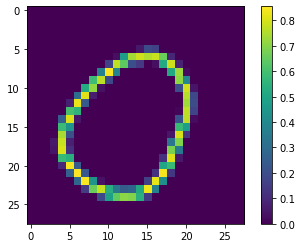

In [44]:
plt.imshow(img)
plt.colorbar()

In [45]:
img[0, 0]

0.0

In [5]:
# Train a model
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)
print(f"Score: {forest.score(X_test, y_test)}")

Score: 0.9653142857142857


Prediction: 4


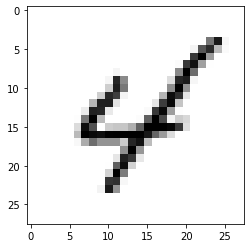

In [8]:
make_prediction_for_random_digit(forest)

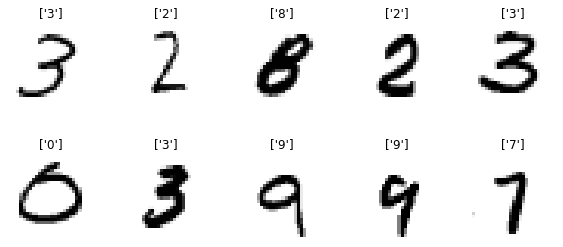

In [9]:
plot_train_data()

0
Prediction: 0
1
Prediction: 7
2
Prediction: 2
3
Prediction: 3
4
Prediction: 4
5
Prediction: 5
6
Prediction: 5
7
Prediction: 2
8
Prediction: 5
9
Prediction: 2


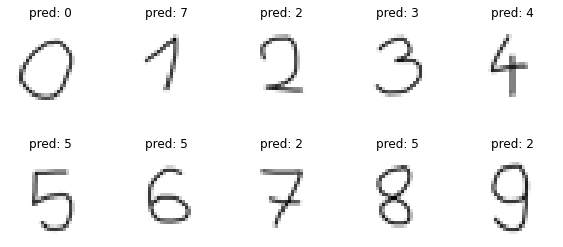

In [10]:
plot_external_data(forest)

## Try Scailable

In [ ]:
# feature_vector = get_random_digit().reshape(1, -1)
# docs = {}
# docs['name'] = "Random forest MNIST demo"
# docs['documentation'] = "#My Random forest MNIST demo."

# sp.upload(forest, feature_vector, docs=docs)
# sp.endpoints()

## Convert model to ONNX format

In [ ]:
# Convert into ONNX format
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
initial_type = [('X', FloatTensorType([None, X_train.shape[1]]))]
onx = convert_sklearn(forest, initial_types=initial_type)
with open("rf_mnist.onnx", "wb") as f:
    f.write(onx.SerializeToString())

# Compute the prediction with ONNX Runtime
import onnxruntime as rt
import numpy
sess = rt.InferenceSession("rf_mnist.onnx")
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([label_name], {input_name: X_test.astype(numpy.float32)})[0]